Generating toy data
Initializing matplotlib
Creating model
Initializing model


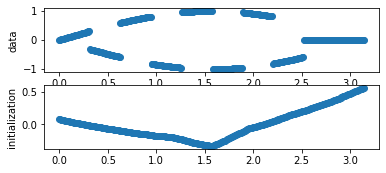

Optimizing
Iter 0/8000, loss 0.5425289273262024
Iter 100/8000, loss 0.313284307718277
Iter 200/8000, loss 0.07331258058547974
Iter 300/8000, loss 0.04261814057826996
Iter 400/8000, loss 0.03155049309134483
Iter 500/8000, loss 0.02567838318645954
Iter 600/8000, loss 0.02142924629151821
Iter 700/8000, loss 0.018512936308979988
Iter 800/8000, loss 0.017459187656641006
Iter 900/8000, loss 0.013317030854523182
Iter 1000/8000, loss 0.011760233901441097
Iter 1100/8000, loss 0.011722041293978691
Iter 1200/8000, loss 0.013641536235809326
Iter 1300/8000, loss 0.008636864833533764
Iter 1400/8000, loss 0.007601458113640547
Iter 1500/8000, loss 0.007181674707680941
Iter 1600/8000, loss 0.007032033521682024
Iter 1700/8000, loss 0.007888782769441605
Iter 1800/8000, loss 0.006519978400319815
Iter 1900/8000, loss 0.010867409408092499
Iter 2000/8000, loss 0.005177628714591265
Iter 2100/8000, loss 0.004982576239854097
Iter 2200/8000, loss 0.0048825847916305065
Iter 2300/8000, loss 0.00578698143362999
Ite

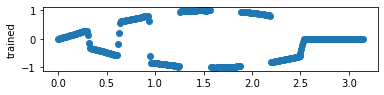

In [16]:
import numpy as np
import matplotlib.pyplot as pp
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" #disable Tensorflow GPU usage, these simple graphs run faster on CPU
import tensorflow as tf

useUnitNormInit=True

class Layer:
    def __init__(self,input:tf.Tensor,initInput:tf.Tensor,nUnits:int,useSkips=True,activation=None):
        X=input
        xDim=X.shape[1].value

        #Default forward pass ops
        #Initial weight matrix rows are random and unit-norm.
        #in other words, if input is unit-variance, output variables are also unit-variance 
        if useUnitNormInit:
            initialW=np.random.normal(0,1,size=[nUnits,xDim])
            initialW=initialW/np.linalg.norm(initialW,axis=1,keepdims=True)
        else:
            #MSRA initialization (https://www.tensorflow.org/api_docs/python/tf/contrib/layers/variance_scaling_initializer)
            initialW=tf.truncated_normal([nUnits,xDim], 0.0, stddev=tf.sqrt(2.0 / xDim))
        self.W=tf.Variable(initial_value=initialW,dtype=tf.float32,name='W')
        self.b=tf.Variable(initial_value=np.zeros([1,nUnits]),dtype=tf.float32,name='b')
        h=tf.matmul(X,tf.transpose(self.W))+self.b
        if activation=="relu":
            h=tf.nn.relu(h)
        elif activation=="selu":
            h=tf.nn.selu(h)
        elif activation=="lrelu":
            h=tf.nn.leaky_relu(h,alpha=0.1)
        elif activation=="tanh":
            h=tf.nn.tanh(h)
        elif activation=="swish":
            h=tf.nn.swish(h)
        elif activation is not None:
            raise NameError("Invalid activation type ({}) for Layer".format(activation))
        if useSkips:
            self.output=tf.concat([X,h],axis=1)
        else:
            self.output=h

        #Init ops for data-dependent initialization pass.
        #Same functionality as above, but we init biases such that the input distribution's mean maps to zero output.
        X=initInput
        xMean=tf.reduce_mean(X,axis=0,keepdims=True)
        b=tf.assign(self.b,-tf.matmul(xMean,tf.transpose(self.W)))
        h=tf.matmul(X,tf.transpose(self.W))+b
        if activation=="relu":
            h=tf.nn.relu(h)
        elif activation=="selu":
            h=tf.nn.selu(h)
        elif activation=="lrelu":
            h=tf.nn.leaky_relu(h,alpha=0.1)
        elif activation=="tanh":
            h=tf.nn.tanh(h)
        elif activation=="swish":
            h=tf.nn.swish(h)
        elif activation is not None:
            raise NameError("Invalid activation type ({}) for Layer".format(activation))
        if useSkips:
            self.initOutput=tf.concat([X,h],axis=1)
        else:
            self.initOutput=h


        
class MLP:
    def __init__(self,input:tf.Tensor,nLayers:int,nUnitsPerLayer:int, nOutputUnits:int, activation="lrelu", firstLinearLayerUnits:int=0, useSkips:bool=True):
        self.layers=[]
        X=input
        initX=input

        #add optional first linear layer (useful, e.g., for reducing the dimensionality of high-dimensional outputs
        #which reduces the parameter count of all subsequent layers)
        if firstLinearLayerUnits!=0:
            layer=Layer(X,initX,firstLinearLayerUnits,useSkips=False,activation=None)
            self.layers.append(layer)
            X,initX=layer.output,layer.initOutput

        #add hidden layers
        for layerIdx in range(nLayers):
            layer=Layer(X,initX,nUnitsPerLayer,useSkips=useSkips,activation=activation)
            self.layers.append(layer)
            X,initX=layer.output,layer.initOutput

        #add output layer
        layer=Layer(X,initX,nOutputUnits,useSkips=False,activation=None)
        self.layers.append(layer)
        self.output,self.initOutput=layer.output,layer.initOutput



    #This method returns a list of assign ops that can be used with a sess.run() call to copy
    #all network parameters from a source network. This is useful, e.g., for implementing a slowly updated
    #target network in Reinforcement Learning
    def copyFromOps(self,src):
        result=[]
        for layerIdx in range(len(self.layers)):
            result.append(tf.assign(self.layers[layerIdx].W,src.layers[layerIdx].W))
            result.append(tf.assign(self.layers[layerIdx].b,src.layers[layerIdx].b))
        return result

#functional interface
def mlp(input:tf.Tensor,nLayers:int,nUnitsPerLayer:int, nOutputUnits:int, activation="selu", firstLinearLayerUnits:int=0,useSkips:bool=True):
    instance=MLP(input,nLayers,nUnitsPerLayer,nOutputUnits,activation,firstLinearLayerUnits)
    return instance.output,instance.initOutput

#simple test: 
if __name__ == "__main__":
    print("Generating toy data")
    x=[]
    y=[]
    maxAngle=5*np.pi
    discontinuousTest=True
    if discontinuousTest:
        maxAngle=np.pi
        for angle in np.arange(0,maxAngle,0.01):
            x.append(angle)
            if angle>maxAngle*0.8:
                y.append(0.0)
            else:
                y.append(np.sin(angle)*np.sign(np.sin(angle*10)))
    else:
        for angle in np.arange(0,maxAngle,0.1):
            r=angle*0.15
            x.append(angle)
            if angle>maxAngle*0.8:
                y.append(0.0)
            else:
                y.append(r*np.sin(angle))

    x=np.array(x)
    y=np.array(y)
    x=np.reshape(x,[x.shape[0],1])
    y=np.reshape(y,[y.shape[0],1])
    interpRange=0.2
    xtest=np.arange(-interpRange+np.min(x),np.max(x)+interpRange,0.001)
    xtest=np.reshape(xtest,[xtest.shape[0],1])
    
    print("Initializing matplotlib")
    pp.figure(1)
    pp.subplot(3,1,1)
    pp.scatter(x[:,0],y[:,0])
    pp.ylabel("data")

    print("Creating model")
    sess=tf.InteractiveSession()
    tfX=tf.placeholder(dtype=tf.float32,shape=[None,1])
    tfY=tf.placeholder(dtype=tf.float32,shape=[None,1])
    #IMPORTANT: deep networks benefit immensely from data-dependent initialization.
    #This is why the constructor returns the initial predictions separately - to initialize, fetch this tensor in a sess.run with 
    #the first minibatch. See the sess.run below
    predictions,initialPredictions=mlp(input=tfX,nLayers=8,nUnitsPerLayer=8,nOutputUnits=1,activation="lrelu")
    optimizer=tf.train.AdamOptimizer()
    loss=tf.losses.mean_squared_error(tfY,predictions)
    optimize=optimizer.minimize(loss)
  
    print("Initializing model")
    tf.global_variables_initializer().run(session=sess)
    #This sess.run() initializes the network biases based on x, and also returns the initial predictions.
    #It is noteworthy that with this initialization, even a deep network has zero-mean output with variance similar to input.
    networkOut=sess.run(initialPredictions,feed_dict={tfX:x})
    pp.subplot(3,1,2)
    pp.scatter(x[:,0],networkOut[:,0])
    pp.ylabel("initialization")
    pp.draw()
    pp.pause(0.001)


    print("Optimizing")
    nIter=8000
    for iter in range(nIter):
        temp,currLoss=sess.run([optimize,loss],feed_dict={tfX:x,tfY:y})
        if iter % 100 == 0:
            print("Iter {}/{}, loss {}".format(iter,nIter,currLoss))
    networkOut=sess.run(predictions,feed_dict={tfX:x})
    pp.subplot(3,1,3)
    pp.scatter(x[:,0],networkOut[:,0])
    pp.ylabel("trained")

    pp.show()

In [45]:
import numpy as np
import random
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" #disable Tensorflow GPU usage, these simple graphs run faster on CPU
import tensorflow as tf

from collections import deque


def softClip(x, minVal, maxVal):
    #return minVal+(maxVal-minVal)*(1.0+0.5*tf.tanh(x))
    return minVal+(maxVal-minVal)*tf.sigmoid(x)

class Policy:
    def __init__(self, stateDim:int, actionDim:int, actionMinLimit:np.array, actionMaxLimit:np.array, mode="PPO-CMA"
                 , entropyLossWeight=0, networkDepth=2, networkUnits=64, networkActivation="lrelu"
                 , networkSkips=False, networkUnitNormInit=True, usePPOLoss=False, separateVarAdapt=False
                 , learningRate=0.001, minSigma=0.01, useSigmaSoftClip=True, PPOepsilon=0.2, piEpsilon=0, nHistory=1
                 , globalVariance=False, trainableGlobalVariance=True, useGradientClipping=False
                 , maxGradientNorm=0.5, negativeAdvantageAvoidanceSigma=0):
        self.networkDepth = networkDepth
        self.networkUnits = networkUnits
        self.networkActivation = networkActivation
        self.networkSkips = networkSkips
        self.networkUnitNormInit = networkUnitNormInit
        self.usePPOLoss = usePPOLoss
        self.separateVarAdapt = separateVarAdapt
        self.learningRate = learningRate
        self.minSigma = minSigma
        self.useSigmaSoftClip=useSigmaSoftClip
        self.PPOepsilon = PPOepsilon
        self.piEpsilon = piEpsilon
        self.nHistory = nHistory
        self.globalVariance = globalVariance
        self.trainableGlobalVariance = trainableGlobalVariance
        self.useGradientClipping = useGradientClipping
        self.maxGradientNorm = maxGradientNorm
        self.negativeAdvantageAvoidanceSigma = negativeAdvantageAvoidanceSigma

        maxSigma=1.0*(actionMaxLimit-actionMinLimit)
        self.mode=mode

        #to be able to benchmark with Schulman's original network architecture, we may have to disable the data-dependent init of the DenseNet module
        useUnitNormInit=self.networkUnitNormInit

        #some bookkeeping
        self.usedSigmaSum=0
        self.usedSigmaSumCounter=0

        #inputs
        stateIn=tf.placeholder(dtype=tf.float32,shape=[None,stateDim],name="stateIn")
        actionIn=tf.placeholder(dtype=tf.float32,shape=[None,actionDim],name="actionIn")    #training targets for policy network
        oldPolicyMean=tf.placeholder(dtype=tf.float32,shape=[None,actionDim],name="oldPolicyMeanIn")    #training targets for policy network
        self.oldPolicyMean=oldPolicyMean
        advantagesIn=tf.placeholder(dtype=tf.float32,shape=[None],name="advantagesIn")     #weights, computed based on action advantages
        logPiOldIn=tf.placeholder(dtype=tf.float32,shape=[None],name="logPiOldIn")             #pi_old(a | s), used for PPO
        initSigmaIn=tf.placeholder(dtype=tf.float32,shape=[1,actionDim],name="initSigmaIn")
        
        #by default, we won't use a linear layer at the beginning of the network to reduce dimensionality
        firstLinearLayerUnits=0

        #First, define the mean and log var tensors, depending on configuration. 
        #Depending on the network architecture, we may also need initialization tensors, fetching which causes a data-dependent initialization of the graph
        policyInit=[]
        if stateDim==0:
            #We don't have state at all => policyMean and variance are simply TensorFlow variables
            policyMean=tf.Variable(initial_value=np.zeros([actionDim]),dtype=tf.float32)
            policyLogVar=tf.Variable(initial_value=np.log(np.square(0.5*(actionMaxLimit-actionMinLimit)))*np.ones([actionDim]),dtype=tf.float32,trainable=self.trainableGlobalVariance)
            self.globalLogVarVariable=policyLogVar
        else:
            #We have state, i.e., need neural networks that output a state-dependent mean and variance
            if self.separateVarAdapt or self.globalVariance:
                #Need separate networks for mean and variance
                policyMean,policyMeanInit=mlp(stateIn,self.networkDepth,self.networkUnits,actionDim,self.networkActivation,firstLinearLayerUnits,self.networkSkips)
                policyInit.append(policyMeanInit)
                if self.globalVariance:
                    policyLogVar=tf.Variable(initial_value=np.log(np.square(0.5*(actionMaxLimit-actionMinLimit)))*np.ones([actionDim]),dtype=tf.float32,trainable=self.trainableGlobalVariance)
                    self.globalLogVarVariable=policyLogVar
                else:
                    policyLogVar,policyLogVarInit=mlp(stateIn,self.networkDepth,self.networkUnits,actionDim,self.networkActivation,firstLinearLayerUnits,self.networkSkips)
                    policyInit.append(policyLogVarInit)
            else:
                #Single network that outputs both mean and variance
                policyMeanAndLogVar,policyMeanAndLogVarInit=mlp(stateIn,self.networkDepth,self.networkUnits,actionDim*2,self.networkActivation,firstLinearLayerUnits,self.networkSkips)
                policyMean=policyMeanAndLogVar[:,:actionDim]
                policyLogVar=policyMeanAndLogVar[:,actionDim:]
                policyInit.append(policyMeanAndLogVarInit)

        #sigmoid-clipping of mean to ensure stability
        policyMean=softClip(policyMean, actionMinLimit,actionMaxLimit)
        if self.useSigmaSoftClip:
            #sigmoid-clipping of log var to ensure stability
            #Note: tanh or hard clipping doesn't work as well due to higher chance of zero or almost zero gradients 
            maxLogVar=np.log(maxSigma*maxSigma)
            minLogVar=np.log(self.minSigma*self.minSigma)
            policyLogVar=softClip(policyLogVar,minLogVar,maxLogVar)
        policyVar=tf.exp(policyLogVar)  
        policySigma=tf.sqrt(policyVar)


        #loss functions
        if self.usePPOLoss:
            def loss(policyMean,policyVar,policyLogVar):
                #1/sqrt(var)=exp(log(1/sqrt(var)))=exp(log(1)-log(var^0.5))=exp(-0.5*log(var))=exp(-log(std))
                logPi=tf.reduce_sum(-0.5*tf.square(actionIn-policyMean)/policyVar-0.5*policyLogVar,axis=1)
                #Some PPO implementations use r=tf.exp(logPi-logPiOldIn). However, we've noticed this to cause NaNs especially
                #with non-saturating policy network activation functions like lrelu and the MuJoCo humanoid env.
                #Thus, we also support using the epsilon below to regularize. 
                if self.piEpsilon==0:
                    r=tf.exp(logPi-logPiOldIn)
                else:
                    r=tf.exp(logPi)/(self.piEpsilon+tf.exp(logPiOldIn))
                perSampleLoss=tf.minimum(r*advantagesIn,tf.clip_by_value(r,1-self.PPOepsilon,1+self.PPOepsilon)*advantagesIn)
                return -tf.reduce_mean(perSampleLoss) #because we want to minimize instead of maximize...
            print("Using PPO clipped surrogate loss with epsilon {}".format(self.PPOepsilon))
            policyLoss=loss(policyMean,policyVar,policyLogVar)
            if entropyLossWeight>0:
                #Entropy of a diagonal Gaussian=0.5*log(det(Cov))=0.5*log(trace(Cov))=0.5*sum(log(diag(Cov)))
                policyLoss-=entropyLossWeight*0.5*tf.reduce_mean(tf.reduce_sum(policyLogVar,axis=1))
            assert(self.separateVarAdapt==False)
            #just to be on the safe side, if some batch has an occasional NaN, set the loss to zero
            policyLoss=tf.where(tf.is_nan(policyLoss), tf.zeros_like(policyLoss),policyLoss)
            policyMeanLoss=policyLoss
            policySigmaLoss=policyLoss
        else:
            #Separate mean and sigma adaptation losses
            policyNoGrad=tf.stop_gradient(policyMean)
            policyVarNoGrad=tf.stop_gradient(policyVar)
            policyLogVarNoGrad=tf.stop_gradient(policyLogVar)
            logpNoMeanGrad=-tf.reduce_sum(0.5*tf.square(actionIn-policyNoGrad)/policyVar+0.5*policyLogVar,axis=1)
            logpNoVarGrad=-tf.reduce_sum(0.5*tf.square(actionIn-policyMean)/policyVarNoGrad+0.5*policyLogVarNoGrad,axis=1) 
            posAdvantages=tf.nn.relu(advantagesIn)
            policySigmaLoss=-tf.reduce_mean(posAdvantages*logpNoMeanGrad)
            policyMeanLoss=-tf.reduce_mean(posAdvantages*logpNoVarGrad)
            if self.negativeAdvantageAvoidanceSigma>0:
                negAdvantages=tf.nn.relu(-advantagesIn)
                mirroredAction=oldPolicyMean-(actionIn-oldPolicyMean)  #mirror negative advantage actions around old policy mean (convert them to positive advantage actions assuming linearity) 
                logpNoVarGradMirrored=-tf.reduce_sum(0.5*tf.square(mirroredAction-policyMean)/policyVarNoGrad+0.5*policyLogVarNoGrad,axis=1) 
                effectiveKernelSqWidth=self.negativeAdvantageAvoidanceSigma*self.negativeAdvantageAvoidanceSigma*policyVarNoGrad
                avoidanceKernel=tf.reduce_mean(tf.exp(-0.5*tf.square(actionIn-oldPolicyMean)/effectiveKernelSqWidth),axis=1)
                policyMeanLoss-=tf.reduce_mean((negAdvantages*avoidanceKernel)*logpNoVarGradMirrored)

            #just to be on the safe side, if some batch has an occasional NaN, set the loss to zero
            policySigmaLoss=tf.where(tf.is_nan(policySigmaLoss), tf.zeros_like(policySigmaLoss),policySigmaLoss)
            policyMeanLoss=tf.where(tf.is_nan(policyMeanLoss), tf.zeros_like(policyMeanLoss),policyMeanLoss)

            #Vanilla Policy Gradient loss
            logp=-tf.reduce_sum(0.5*tf.square(actionIn-policyMean)/policyVar+0.5*policyLogVar,axis=1)
            policyLoss=tf.reduce_mean(-advantagesIn*logp)  

        #loss functions for initialization (pretraining)
        policyInitLoss=tf.reduce_mean(tf.square(actionIn-policyMean))
        policyInitLoss+=tf.reduce_mean(tf.square(initSigmaIn-policySigma))

        #optimizers
        def optimize(loss):
            optimizer=tf.train.AdamOptimizer(learning_rate=self.learningRate)
            if not self.useGradientClipping:
                return optimizer.minimize(loss)
            gradients, variables = zip(*optimizer.compute_gradients(loss))
            gradients, _ = tf.clip_by_global_norm(gradients, self.maxGradientNorm)
            return optimizer.apply_gradients(zip(gradients, variables))
        self.optimizePolicy=optimize(policyLoss)
        self.optimizePolicySigma=optimize(policySigmaLoss)
        self.optimizePolicyMean=optimize(policyMeanLoss)
        self.optimizePolicyInit=optimize(policyInitLoss)

        #cache stuff needed elsewhere
        self.actionMinLimit=actionMinLimit
        self.actionMaxLimit=actionMaxLimit
        self.stateDim=stateDim
        self.actionDim=actionDim
        self.policyMean=policyMean
        self.stateIn=stateIn
        self.actionIn=actionIn
        self.policyInit=policyInit
        self.policyInitLoss=policyInitLoss
        self.advantagesIn=advantagesIn
        self.policyLoss=policyLoss
        self.logPiOldIn=logPiOldIn
        self.initSigmaIn=initSigmaIn
        self.history=deque()
        self.policyVar=policyVar
        self.policyLogVar=policyLogVar
        self.policySigma=policySigma
        self.initialized=False  #remember that one has to call init() before training (can't call it here as TF globals might not have been initialized yet)

    #init the policy with random Gaussian state samples, such that the network outputs the desired mean and sd
    def init(self,sess:tf.Session,stateMean:np.array,stateSd:np.array,actionMean:np.array,actionSd:np.array,nMinibatch:int=64,nBatches:int=4000,verbose=True):
        for batchIdx in range(nBatches):
            states=np.random.normal(stateMean,stateSd,size=[nMinibatch,self.stateDim])
            if batchIdx==0 and len(self.policyInit)>0:
                #init the MLP biases to prevent large values
                temp,currLoss=sess.run([self.policyInit,self.policyInitLoss],feed_dict={self.stateIn:states,self.actionIn:np.reshape(actionMean,[1,self.actionDim]),self.initSigmaIn:np.reshape(actionSd,[1,self.actionDim])})
            else:
                #drive output towards the desired mean and sd
                temp,currLoss=sess.run([self.optimizePolicyInit,self.policyInitLoss],feed_dict={self.stateIn:states,self.actionIn:np.reshape(actionMean,[1,self.actionDim]),self.initSigmaIn:np.reshape(actionSd,[1,self.actionDim])})
            if verbose and (batchIdx % 100 ==0):
                print("Initializing policy with random Gaussian data, batch {}/{}, loss {}".format(batchIdx,nBatches,currLoss))
        self.initialized=True
    #init the policy with uniform random state samples, such that the network outputs the desired mean and sd
    def initUniform(self,sess:tf.Session,stateMin:np.array,stateMax:np.array,actionMean:np.array,actionSd:np.array,nMinibatch:int=64,nBatches:int=4000):
        for batchIdx in range(nBatches):
            states=np.random.uniform(stateMin,stateMax,size=[nMinibatch,self.stateDim])
            if batchIdx==0 and len(self.policyInit)>0:
                #init the MLP biases to prevent large values
                temp,currLoss=sess.run([self.policyInit,self.policyInitLoss],feed_dict={self.stateIn:states,self.actionIn:np.reshape(actionMean,[1,self.actionDim]),self.initSigmaIn:np.reshape(actionSd,[1,self.actionDim])})
            else:
                #drive output towards the desired mean and sd
                temp,currLoss=sess.run([self.optimizePolicyInit,self.policyInitLoss],feed_dict={self.stateIn:states,self.actionIn:np.reshape(actionMean,[1,self.actionDim]),self.initSigmaIn:np.reshape(actionSd,[1,self.actionDim])})
            if batchIdx % 100 ==0:
                print("Initializing policy with random Gaussian data, batch {}/{}, loss {}".format(batchIdx,nBatches,currLoss))
        self.initialized=True
    #if nBatches==0, nEpochs will be used
    def train(self,sess:tf.Session,states:np.array,actions:np.array,advantages:np.array,nMinibatch:int,nEpochs:int,nBatches:int=0,stateOffset=0,stateScale=1,verbose=True):
        assert(np.all(np.isfinite(states)))
        assert(np.all(np.isfinite(actions)))
        assert(np.all(np.isfinite(advantages)))
        assert(self.initialized)
        nData=actions.shape[0]

        #reset bookkeeping for next iter
        self.usedSigmaSum=0
        self.usedSigmaSumCounter=0

        #manage history
        self.history.append([states.copy(),actions.copy(),advantages.copy()])
        if len(self.history)>self.nHistory:
            self.history.popleft()

        #safety-check that the observed state distribution is at least roughly zero-mean unit sd
        if self.stateDim>0:
            scaledStates=(states-stateOffset)*stateScale
            stateAbsMax=np.max(np.absolute(scaledStates))
            if stateAbsMax>10:
                print("Warning: states deviate up to {} sd:s from expected!".format(stateAbsMax))
        else:
            scaledStates=states
        #train
        assert(len(advantages.shape)==1)  #to prevent nasty silent broadcasting bugs
        nMinibatch=min([nData,nMinibatch])
        if nBatches==0:
            nBatches=max([1,int(nData*nEpochs/nMinibatch)])
        #nBatches=1000
        nVarAdaptBatches=nBatches
        mbStates=np.zeros([nMinibatch,self.stateDim])
        mbActions=np.zeros([nMinibatch,self.actionDim])
        mbOldMean=np.zeros([nMinibatch,self.actionDim])
        mbAdvantages=np.zeros([nMinibatch])
        logPiOld=np.ones([nData])
        mbLogPiOld=np.ones([nMinibatch])
        if self.usePPOLoss:
            policyMean,policyVar,policyLogVar=sess.run([self.policyMean,self.policyVar,self.policyLogVar],feed_dict={self.stateIn:scaledStates})
            #for i in range(nData):
            #    logPiOld[i]=np.sum(-0.5*np.square(actions[i,:]-policyMean[i,:])/policyVar[i,:]-0.5*policyLogVar[i,:])
            logPiOld=np.sum(-0.5*np.square(actions-policyMean)/policyVar-0.5*policyLogVar,axis=1)
        if self.separateVarAdapt:
            assert(self.usePPOLoss==False)
            #if negativeAdvantageAvoidanceSigma>0:
            oldMeans=sess.run(self.policyMean,{self.stateIn:scaledStates})
            for batchIdx in range(nBatches + nVarAdaptBatches if self.separateVarAdapt else nBatches):
                if batchIdx<nVarAdaptBatches:
                    historyLen=len(self.history)
                    for i in range(nMinibatch):
                        histIdx=np.random.randint(0,historyLen)
                        h=self.history[histIdx]
                        nData=h[1].shape[0]
                        dataIdx=np.random.randint(0,nData)
                        mbStates[i,:]=h[0][dataIdx,:]
                        mbActions[i,:]=h[1][dataIdx,:]
                        mbAdvantages[i]=h[2][dataIdx]
                    advantageMean=np.mean(mbAdvantages)
                    mbStates=(mbStates-stateOffset)*stateScale  #here, we must scale per batch because using the history
                    temp,currLoss=sess.run([self.optimizePolicySigma,self.policyLoss],feed_dict={self.stateIn:mbStates,self.actionIn:mbActions,self.advantagesIn:mbAdvantages})
                    if verbose and (batchIdx % 100 == 0):
                        print("Adapting policy variance, batch {}/{}, mean advantage {:.2f}, loss {}".format(batchIdx,nVarAdaptBatches,advantageMean,currLoss))
                #temp,currLoss=sess.run([self.optimizePolicyMean,self.policyLoss],feed_dict={self.stateIn:mbStates,self.actionIn:mbActions,self.advantagesIn:mbAdvantages})
                else:
                    nData=actions.shape[0]
                    for i in range(nMinibatch):
                        dataIdx=np.random.randint(0,nData)
                        mbStates[i,:]=scaledStates[dataIdx,:]  
                        mbActions[i,:]=actions[dataIdx,:]
                        if self.stateDim>0:
                            mbOldMean[i,:]=oldMeans[dataIdx,:]
                        mbAdvantages[i]=advantages[dataIdx]
                    advantageMean=np.mean(mbAdvantages)
                    temp,currLoss=sess.run([self.optimizePolicyMean,self.policyLoss],feed_dict={self.stateIn:mbStates,self.actionIn:mbActions,self.advantagesIn:mbAdvantages,self.logPiOldIn:mbLogPiOld, self.oldPolicyMean:mbOldMean})
                    if verbose and (batchIdx % 100 == 0):
                        print("Adapting policy mean, batch {}/{}, mean advantage {:.2f}, loss {}".format(batchIdx-nVarAdaptBatches,nBatches,advantageMean,currLoss))

        else:
            for batchIdx in range(nBatches + nVarAdaptBatches if self.separateVarAdapt else nBatches):
                for i in range(nMinibatch):
                    dataIdx=np.random.randint(0,nData)
                    if self.stateDim!=0:
                        mbStates[i,:]=scaledStates[dataIdx,:]
                    mbActions[i,:]=actions[dataIdx,:]
                    mbAdvantages[i]=advantages[dataIdx]
                    mbLogPiOld[i]=logPiOld[dataIdx]
                advantageMean=np.mean(mbAdvantages)
                temp,currLoss=sess.run([self.optimizePolicy,self.policyLoss],feed_dict={self.stateIn:mbStates,self.actionIn:mbActions,self.advantagesIn:mbAdvantages,self.logPiOldIn:mbLogPiOld})
                if verbose and (batchIdx % 100 == 0):
                    print("Training policy, batch {}/{}, mean advantage {:.2f}, loss {}".format(batchIdx,nBatches,advantageMean,currLoss))
    def setGlobalStdev(self,relStdev:float, sess:tf.Session):
        assert(self.globalVariance and (not self.trainableGlobalVariance))
        stdev=relStdev*(self.actionMaxLimit-self.actionMinLimit)
        var=np.square(stdev)
        logVar=np.log(var)
        self.globalLogVarVariable.load(logVar,sess)
        
    def sample(self,sess:tf.Session,observations:np.array,enforcedRelSigma:float=None):
        obs=observations
        nObs=obs.shape[0]
        result=np.zeros([nObs,self.actionDim])
        assert(self.initialized)
        policyMean,policySigma=sess.run([self.policyMean,self.policySigma],feed_dict={self.stateIn:obs})
        if np.any(np.isnan(policyMean)):
            raise Exception("Policy mean is NaN")
        if np.any(np.isnan(policySigma)):
            raise Exception("Policy sigma is NaN")
        #if np.any(policySigma<minSigma):
        #    raise Exception("Policy sigma violates limits")

        for i in range(nObs):
            if self.stateDim==0:
                result[i,:]=np.random.normal(policyMean,policySigma,[self.actionDim])
            else:
                if self.globalVariance:
                    result[i,:]=np.random.normal(policyMean[i,:],policySigma,[self.actionDim])
                else:
                    result[i,:]=np.random.normal(policyMean[i,:],policySigma[i,:],[self.actionDim])

        #bookkeeping for logging
        self.usedSigmaSum+=np.mean(policySigma)
        self.usedSigmaSumCounter+=1
        return result
    def getExpectation(self,sess:tf.Session,observations:np.array):
        return sess.run(self.policyMean,feed_dict={self.stateIn:observations})
    def getSd(self,sess:tf.Session,observations:np.array):
        return sess.run(self.policySigma,feed_dict={self.stateIn:observations})
    #def get2dEllipse(self,observations:np.array):
    #    def logProb(self,state:np.array,action:np.array):
    #    def adapt(self,states:np.array,actions:np.array,advantages:np.array,batchSize:int,nEpochs:int):

In [46]:
import numpy as np
import random
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" #disable Tensorflow GPU usage, these simple graphs run faster on CPU
import tensorflow as tf

from collections import deque

useGradientClipping=False
maxGradientNorm=1

#A function that behaves like abs, but has zero derivative at the origin, which should improve final convergence if this is 
#used in computing a loss 
def softAbs(x:tf.Tensor):
    x=tf.abs(x)
    return tf.where(x > 0.5, x-0.25, x*x)

class Critic:
    def __init__(self,stateDim:int,nHidden:int,networkUnits:int,networkActivation,useSkips=False,learningRate:float=1e-3,nHistory:int=1,lossType="L2"):
        stateIn=tf.placeholder(dtype=tf.float32,shape=[None,stateDim])
        valueIn=tf.placeholder(dtype=tf.float32,shape=[None,1])             #training targets for value network
        critic,criticInit=mlp(stateIn,nHidden,networkUnits,1,networkActivation,firstLinearLayerUnits=0,useSkips=useSkips)  #need a handle for the DenseNet instance for network switching
        diff=valueIn-critic
        if lossType=="L2":
            loss=tf.reduce_mean(tf.square(diff))    
        elif lossType=="L1":
            loss=tf.reduce_mean(tf.abs(diff))       #L1 loss, can be more stable
        elif lossType=="SoftL1":
            loss=tf.reduce_mean(softAbs(diff))       #L1 loss with zero gradient at optimum
        else:
            raise Exception("Loss type not recognized!")
        def optimize(loss):
            optimizer=tf.train.AdamOptimizer(learning_rate=learningRate)
            if not useGradientClipping:
                return optimizer.minimize(loss)
            gradients, variables = zip(*optimizer.compute_gradients(loss))
            gradients, _ = tf.clip_by_global_norm(gradients, maxGradientNorm)
            return optimizer.apply_gradients(zip(gradients, variables))
        optimizeCritic=optimize(loss)
        #remember some of the tensors for later
        self.loss=loss
        self.nHistory=nHistory
        self.history=deque()
        self.criticInit=criticInit
        self.stateIn=stateIn
        self.valueIn=valueIn
        self.initialized=False
        self.stateDim=stateDim
        self.critic=critic
        self.optimize=optimizeCritic

    def train(self,sess,states:np.array,values:np.array,nMinibatch:int,nEpochs:int,nBatches:int=0,verbose=True):
        assert(np.all(np.isfinite(states)))
        assert(np.all(np.isfinite(values)))
        nData=states.shape[0]

        #manage history
        self.history.append([states.copy(),values.copy()])
        if len(self.history)>self.nHistory:
            self.history.popleft()

        #train
        nMinibatch=min([nData,nMinibatch])
        if nBatches==0:
            nBatches=max([1,int(nData*nEpochs/nMinibatch)])
        mbState=np.zeros([nMinibatch,self.stateDim])
        mbValue=np.zeros([nMinibatch,1])
        for batchIdx in range(nBatches):
            historyLen=len(self.history)
            for i in range(nMinibatch):
                histIdx=np.random.randint(0,historyLen)
                h=self.history[histIdx]
                nData=h[0].shape[0]
                dataIdx=np.random.randint(0,nData)
                mbState[i,:]=h[0][dataIdx,:]
                mbValue[i]=h[1][dataIdx]
            if batchIdx==0 and not self.initialized:
                #init the MLP biases to prevent large values
                temp,currLoss=sess.run([self.criticInit,self.loss],feed_dict={self.stateIn:mbState,self.valueIn:mbValue})
                self.initialized=True
            else:
                temp,currLoss=sess.run([self.optimize,self.loss],feed_dict={self.stateIn:mbState,self.valueIn:mbValue})
            if verbose and (batchIdx % 100 == 0):
                print("Training critic, batch {}/{}, loss {}".format(batchIdx,nBatches,currLoss))
    def predict(self,sess,states):
        return sess.run(self.critic,feed_dict={self.stateIn:states})

In [47]:
"""
Data Scaling Utilities
Modified from code by Patrick Coady (pat-coady.github.io)
"""
import numpy as np
import os


class Scaler(object):
    """ Generate scale and offset based on running mean and stddev along axis=0
        offset = running mean
        scale = 1 / (2.0*stddev + epsilon) 
    """

    def __init__(self, obs_dim, epsilon=0.001, clip=1e10, useOffset=False):
        """
        Args:
            obs_dim: dimension of axis=1
        """
        self.xMean=np.zeros(obs_dim)
        self.xSqMean=np.zeros(obs_dim)
        self.scale=np.ones(obs_dim)
        self.offset=np.zeros(obs_dim)
        self.nUpdates=0
        self.epsilon=epsilon
        self.clip=clip
        self.useOffset=useOffset

    def update(self, x):
        self.nUpdates+=1
        newWeight=1/self.nUpdates
        self.xSqMean=(1-newWeight)*self.xSqMean+newWeight*np.mean(np.square(x),axis=0) 
        self.xMean=(1-newWeight)*self.xMean+newWeight*np.mean(x,axis=0) 
        if self.useOffset:
            mean=self.xMean
        else:
            mean=0
        #var(x)=E((x-mean(x))^2)=E(x^2-2*x*E(x)+mean(x)^2)=E(x^2)-2*E(x)*E(x)+E(x)^2=E(x^2)-E(x)^2
        var=self.xSqMean-np.square(mean)
        var=np.maximum(0.0,var)
        self.scale=np.minimum(self.scale,1.0/(2.0*np.sqrt(var)+self.epsilon))  
        self.offset=mean

    def get(self):
        """ returns 2-tuple: (scale, offset) """
        return self.scale,self.offset

    def process(self,x:np.array):
        return np.clip((x-self.offset)*self.scale,-self.clip,self.clip)
    def unscale(self,x:np.array):
        return x/self.scale+self.offset
    

    
class MinMaxScaler(object):
    """ Generate scale and offset based on low-pass filtered max and min vals
    """

    def __init__(self, obs_dim, filter=0.9, epsilon=0.001, useOffset=False, scalarMode=True):
        """
        Args:
            obs_dim: dimension of axis=1
        """
        self.minVals=-np.ones(obs_dim)
        self.maxVals=np.zeros(obs_dim)
        self.filteredMinVals=self.minVals.copy()
        self.filteredMaxVals=self.maxVals.copy()
        self.first_pass = True
        self.filter=filter
        self.epsilon=epsilon
        self.scalarMode=scalarMode
        self.useOffset=useOffset
        self.scale=1 if scalarMode else np.ones(obs_dim)
        self.offset=0 if scalarMode else np.zeros(obs_dim)

    def update(self, x):
        if self.first_pass:
            self.minVals=np.min(x,axis=0)
            self.maxVals=np.max(x,axis=0)
            self.filteredMinVals=self.minVals.copy()
            self.filteredMaxVals=self.maxVals.copy()
        else:
            self.minVals=np.minimum([self.minVals,np.min(x,axis=0)])
            self.maxVals=np.maximum([self.maxVals,np.max(x,axis=0)])
            self.filteredMinVals=self.filter*self.filteredMinVals+(1-self.filter)*self.minVals
            self.filteredMaxVals=self.filter*self.filteredMaxVals+(1-self.filter)*self.maxVals
        if self.scalarMode:
            self.scale=np.minimum(self.scale,2.0/np.max((self.filteredMaxVals-self.filteredMinVals)+self.epsilon))
        else:
            self.scale=2.0/((self.filteredMaxVals-self.filteredMinVals)+self.epsilon)
            if self.useOffset:
                self.offset=0.5*(self.filteredMaxVals+self.filteredMinVals)

    def get(self):
        """ returns 2-tuple: (scale, offset) """
        return self.scale,self.offset

In [60]:
'''
Known issues (TODO): 
- policy.train() takes as input the scaler scale and offset, and uses them internally. However, the scaler also has a clip parameter, which is
  by default set to a large value, but if one wants to use it, scaler.process() will then produce different results than the scaling in policy.train()
  - fix: policy should take the Scaler instance as an argument, although this creates a dependency
'''

import numpy as np
import math
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" #disable Tensorflow GPU usage, these simple graphs run faster on CPU
import tensorflow as tf


#Data structure for holding experience
class Experience:
    def __init__(self,s:np.array,a:np.array,r:float,s_next:np.array,terminated:bool,timeStep=0):
        self.s=s.copy()
        self.a=a
        self.r=r
        self.s_next=s_next.copy()
        self.terminated=terminated
        self.timeStep=timeStep     
        self.V=r            #value, will be updated by the agent or the client. note: this is the on-policy value, i.e., averaged over children
        self.Vselect=r      #value used for the UCB
        self.advantage=0    #will be updated by the agent
        self.nonDiscountedRewardSum=0   #used in some applications
        self.fullState=None #used in tree search
        #the following only used when building trajectory trees
        self.parent=None
        self.children=[]
        self.depth=1
        #visitation count used by UCB tree search
        self.n=1

    #Updates value upwards in the tree, called after adding a new trajectory to the tree.
    #Also keeps track of tree depth
    def propagateUpwards(self,gamma:float,bestGamma:float=1):
        node=self
        node.V=node.r
        node.Vselect=node.r
        while node.parent is not None:
            node=node.parent
            node.V=node.r
            node.Vselect=-np.inf
            nChildren=len(node.children)
            node.depth=0
            for child in node.children:
                node.V+=gamma*child.V/nChildren
                node.Vselect=max([node.Vselect,node.r+bestGamma*child.Vselect])
                node.depth=max([node.depth,child.depth+1])
            #node.Vselect=node.V

    #adds a child to this node, updating tree linkage
    def addChild(self,child):
        self.children.append(child)
        child.parent=self

    #selects a child node at specific depth, using the UCB formula to visit the children
    def selectChildAtDepth(self,depth,C_ucb):
        node=self
        self.n+=1       #keep track of visitation count
        while depth>0:
            nChildren=len(node.children)
            if nChildren==1:
                #if only one child, just move forward
                node=node.children[0]
            else:
                #if multiple children, select the best-scoring one based on the UCB-1 formula
                maxScore=-np.inf
                maxScoringChild=None
                for child in node.children:
                    if child.depth>=depth:  #we only accept branches that will take us up to the desired depth
                        score=node.Vselect+C_ucb*math.sqrt(math.log(node.n)/child.n)
                        if score>maxScore:
                            maxScoringChild=child
                            maxScore=score
                node=maxScoringChild
            depth-=1        #keep track of depth
            node.n+=1       #keep track of visitation count
        return node

class Agent:
    #In most cases, one only needs to specify stateDim, actionDim, actionMin, and actionMax.
    #The mode parameter defines the algorithm. PPO-CMA-m is the default, i.e., PPO-CMA using the sample mirroring trick.
    #Other choices are "PPO-CMA", "PPO", "PG" and "PG-pos". The two last modes denote vanilla policy gradient, and the "-pos"
    #means that only positive advantage actions are used. See DidacticExample.py for visualization of different modes in a simple quadratic problem.
    def __init__(self, stateDim:int, actionDim:int, actionMin:np.array, actionMax:np.array, learningRate=0.0005
                 , gamma=0.99, GAElambda=0.95, PPOepsilon=0.2, PPOentropyLossWeight=0, nHidden:int=2
                 , nUnitsPerLayer:int=128, mode="PPO-CMA-m", activation="lrelu", H:int=9, entropyLossWeight:float=0
                 , sdLowLimit=0.01, useScaler:bool=True, criticTimestepScale=0.001,initialMean:np.array=None,initialSd:np.array=None):
        #Create policy network 
        print("Creating policy")
        self.actionMin=actionMin
        self.actionMax=actionMax
        self.actionDim=actionDim
        self.stateDim=stateDim
        self.useScaler=useScaler
        if useScaler:
            self.scaler=Scaler(stateDim)
        self.scalerInitialized=False
        self.normalizeAdvantages=True
        self.gamma=gamma
        self.GAElambda=GAElambda
        self.criticTimestepScale=0 if gamma==0 else criticTimestepScale     #with gamma==0, no need for this
        piEpsilon = None
        nHistory = 1
        negativeAdvantageAvoidanceSigma = 0
        if mode=="PPO-CMA" or mode=="PPO-CMA-m":
            usePPOLoss=False           #if True, we use PPO's clipped surrogate loss function instead of the standard -A_i * log(pi(a_i | s_i))
            separateVarAdapt=True
            self.reluAdvantages=True if mode=="PPO-CMA" else False
            nHistory=H             #policy mean adapts immediately, policy covariance as an aggreagate of this many past iterations
            useSigmaSoftClip=True
            negativeAdvantageAvoidanceSigma=1 if mode=="PPO-CMA-m" else 0
        elif mode=="PPO":
            usePPOLoss=True           #if True, we use PPO's clipped surrogate loss function instead of the standard -A_i * log(pi(a_i | s_i))
            separateVarAdapt = False
            # separateSigmaAdapt=False
            self.reluAdvantages=False
            useSigmaSoftClip=True
            piEpsilon=0
        elif mode=="PG":
            usePPOLoss=False           #if True, we use PPO's clipped surrogate loss function instead of the standard -A_i * log(pi(a_i | s_i))
            separateVarAdapt = False
            # separateSigmaAdapt=False
            self.reluAdvantages=False
            useSigmaSoftClip=True
            piEpsilon=0
        elif mode=="PG-pos":
            usePPOLoss=False           #if True, we use PPO's clipped surrogate loss function instead of the standard -A_i * log(pi(a_i | s_i))
            separateVarAdapt = False
            # separateSigmaAdapt=False
            self.reluAdvantages=True
            useSigmaSoftClip=True
            piEpsilon=0
        else:
            raise("Unknown mode {}".format(mode))
        self.policy=Policy(stateDim, actionDim, actionMin, actionMax, entropyLossWeight=PPOentropyLossWeight
                           , networkActivation=activation, networkDepth=nHidden, networkUnits=nUnitsPerLayer
                           , networkSkips=False, learningRate=learningRate, minSigma=sdLowLimit, PPOepsilon=PPOepsilon
                           , usePPOLoss=usePPOLoss, separateVarAdapt=separateVarAdapt, nHistory=nHistory
                           , useSigmaSoftClip=useSigmaSoftClip, piEpsilon=piEpsilon
                           , negativeAdvantageAvoidanceSigma=negativeAdvantageAvoidanceSigma)

        #Create critic network, +1 stateDim because at least in OpenAI gym, episodes are time-limited and the value estimates thus depend on simulation time.
        #Thus, we use time step as an additional feature for the critic.
        #Note that this does not mess up generalization, as the feature is not used for the policy during training or at runtime
        print("Creating critic network")
        self.critic=Critic(stateDim=stateDim+1,learningRate=learningRate,nHidden=nHidden,networkUnits=nUnitsPerLayer,networkActivation=activation,useSkips=False,lossType="L1")

        #Experience trajectory buffers for the memorize() and updateWithMemorized() methods
        self.experienceTrajectories=[]
        self.currentTrajectory=[]

        #Init may take as argument a desired initial action mean and sd. These need to be remembered for the first iteration's act,
        #which samples the initial mean and sd directly instead of utilizing the policy network.
        if initialMean is not None:
            self.initialMean=initialMean.copy()
        else:
            self.initialMean=0.5*(self.actionMin+self.actionMax)*np.ones(self.actionDim)
        if initialSd is not None:
            self.initialSd=initialSd.copy()
        else:
            self.initialSd=0.5*(self.actionMax-self.actionMin)*np.ones(self.actionDim)

    #call this after tensorflow's global variables initializer
    def init(self,sess:tf.Session,verbose=False):
        #Pretrain the policy to output the initial Gaussian for all states
        self.policy.init(sess,0,1,self.initialMean,self.initialSd,256,2000,verbose)
    
    #stateObs is an n-by-m tensor, where n = number of observations, m = number of observation variables
    def act(self,sess:tf.Session,stateObs:np.array,deterministic=False,clipActionToLimits=True):
        #Expand a single 1d-observation into a batch of 1 vectors
        if len(stateObs.shape)==1:
            stateObs=np.reshape(stateObs,[1,stateObs.shape[0]])
        #Query the policy for the action, except for the first iteration where we sample directly from the initial exploration Gaussian
        #that covers the whole action space.
        #This is done because we don't know the scale of state observations a priori; thus, we can only init the state scaler in update(), 
        #after we have collected some experience.
        if self.useScaler and (not self.scalerInitialized):
            actions=np.random.normal(self.initialMean,self.initialSd,size=[stateObs.shape[0],self.actionDim])
            if clipActionToLimits:
                actions=np.clip(actions,np.reshape(self.actionMin,[1,self.actionDim]),np.reshape(self.actionMax,[1,self.actionDim]))
            return actions
        else:
            if self.useScaler:
                scaledObs=self.scaler.process(stateObs)
            else:
                scaledObs=stateObs
            if deterministic:
                actions=self.policy.getExpectation(sess,scaledObs)
            else:
                actions=self.policy.sample(sess,scaledObs)
            if clipActionToLimits:
                actions=np.clip(actions,self.actionMin,self.actionMax)
            return actions
    def memorize(self,observation:np.array,action:np.array,reward:float,nextObservation:np.array,done:bool):
        e = Experience(observation, action, reward, nextObservation, done)
        self.currentTrajectory.append(e)
        if done:
            self.experienceTrajectories.append(self.currentTrajectory)
            self.currentTrajectory=[]

    def getAverageActionStdev(self):
        if self.useScaler and (not self.scalerInitialized):
            return np.mean(0.5*(self.actionMax-self.actionMin))
        else:
            return self.policy.usedSigmaSum/(1e-20+self.policy.usedSigmaSumCounter)

    #If you call memorize() after each action, you can update the agent with this method. 
    #If you handle the experience buffers yourself, e.g., due to a multithreaded implementation, use the update() method instead.
    def updateWithMemorized(self,sess:tf.Session,batchSize:int=512,nBatches:int=100,verbose=True,valuesValid=False,timestepsValid=False):
        self.update(sess,experienceTrajectories=self.experienceTrajectories,batchSize=batchSize,nBatches=nBatches,verbose=verbose,valuesValid=valuesValid,timestepsValid=timestepsValid)
        averageEpisodeReturn=0
        for t in self.experienceTrajectories:
            episodeReturn=0
            for e in t:
                episodeReturn+=e.r
            averageEpisodeReturn+=episodeReturn
        averageEpisodeReturn/=len(self.experienceTrajectories)
        self.experienceTrajectories=[]
        self.currentTrajectory=[]
        return averageEpisodeReturn

    #experienceTrajectories is a list of lists of Experience instances such that each of the contained lists corresponds to an episode simulation trajectory
    def update(self,sess:tf.Session,experienceTrajectories,batchSize:int=512,nBatches:int=100,verbose=True,valuesValid=False,timestepsValid=False):
        trajectories=experienceTrajectories   #shorthand

        #Collect all data into linear arrays for training. 
        nTrajectories=len(trajectories)
        nData=0
        for trajectory in trajectories:
            nData+=len(trajectory)
            #propagate values backwards along trajectory if not already done
            if not valuesValid:
                for i in reversed(range(len(trajectory)-1)):
                    #value estimates, used for training the critic and estimating advantages
                    trajectory[i].V=trajectory[i].r+self.gamma*trajectory[i+1].V
            #update time steps if not updated
            if not timestepsValid:
                for i in range(len(trajectory)):
                    trajectory[i].timeStep=i
        allStates=np.zeros([nData,self.stateDim])
        allActions=np.zeros([nData,self.actionDim])
        allValues=np.zeros([nData])
        allTimes=np.zeros([nData,1])
        k=0
        for trajectory in trajectories:
            for e in trajectory:
                allStates[k,:]=e.s
                allValues[k]=e.V  
                allActions[k,:]=e.a
                allTimes[k,0]=e.timeStep*self.criticTimestepScale 
                k+=1


        #Update scalers
        if self.useScaler:
            self.scaler.update(allStates)
            scale, offset = self.scaler.get()
            self.scalerInitialized=True
        else:
            offset=0
            scale=1
 
        #Scale the observations for training the critic
        scaledStates=self.scaler.process(allStates)

        #Train critic
        def augmentCriticObs(obs:np.array,timeSteps:np.array):
            return np.concatenate([obs,timeSteps],axis=1)
        self.critic.train(sess,augmentCriticObs(scaledStates,allTimes),allValues,batchSize,nEpochs=0,nBatches=nBatches,verbose=verbose)

        #Policy training needs advantages, which depend on the critic we just trained.
        #We use Generalized Advantage Estimation by Schulman et al.
        if verbose:
            print("Estimating advantages...".format(len(trajectories)))
        for t in trajectories:
            #query the critic values of all states of this trajectory in one big batch
            nSteps=len(t)
            states=np.zeros([nSteps+1,self.stateDim])
            timeSteps=np.zeros([nSteps+1,1])
            for i in range(nSteps):
                states[i,:]=t[i].s
                timeSteps[i,0]=t[i].timeStep*self.criticTimestepScale
            states[nSteps,:]=t[nSteps-1].s_next
            states=(states-offset)*scale
            values=self.critic.predict(sess,augmentCriticObs(states,timeSteps))

            #GAE loop, i.e., take the instantaneous advantage (how much value a single action brings, assuming that the
            #values given by the critic are unbiased), and smooth those along the trajectory using 1st-order IIR filter.
            advantage=0
            for step in reversed(range(nSteps)):
                delta_t=t[step].r+self.gamma*values[step+1] - values[step]
                advantage=delta_t+self.GAElambda*self.gamma*advantage
                t[step].advantage=advantage

        #Gather the advantages to linear array and apply ReLU and normalization if needed
        allAdvantages=np.zeros([nData])
        k=0
        for trajectory in trajectories:
            for e in trajectory:
                allAdvantages[k]=e.advantage  
                k+=1

        if self.reluAdvantages:
            allAdvantages=np.clip(allAdvantages,0,np.inf)
        if self.normalizeAdvantages:
            aMean=np.mean(allAdvantages)
            aSd=np.std(allAdvantages)
            if verbose:
                print("Advantage mean {}, sd{}".format(aMean,aSd))
            allAdvantages/=1e-10+aSd
            #Clamp the normalized advantages to 3 sd:s, in case of outliers. 
            #Commented out for now to allow computing additional ICML results, as this was not yet implemented in the ICML version
            #advantageLimit=3
            #allAdvantages=np.clip(allAdvantages,-advantageLimit,advantageLimit)

        #Train policy. Note that this uses original unscaled states, because the PPO-CMA variance training needs a history of
        #states in the same scale
        self.policy.train(sess,allStates,allActions,allAdvantages,batchSize,nEpochs=0,nBatches=nBatches,stateOffset=offset,stateScale=scale,verbose=verbose)
            


In [61]:
import gym
import tensorflow as tf

#Simulation budget (steps) per iteration. This is the main parameter to tune.
#8k works for relatively simple environments like the OpenAI Gym Roboschool 2D Hopper.
#For more complex problems such as 3D humanoid locomotion, try 32k or even 64k.
#Larger values are slower but more robust.
N=2000

# Stop training after this many steps
max_steps=1000000

# Init tensorflow
sess = tf.InteractiveSession()

# Create environment (replace this with your own simulator)
print("Creating simulation environment")
sim = gym.make("CartPole-v0")

# Create the agent using the default parameters for the neural network architecture
agent=Agent(
    stateDim=sim.observation_space.low.shape[0]
    , actionDim=1
    , actionMin=0
    , actionMax=1
)

Creating simulation environment
Creating policy
Creating critic network


In [62]:
# Finalize initialization
tf.global_variables_initializer().run(session=sess)
agent.init(sess)  # must be called after TensorFlow global variables init

# Main training loop
totalSimSteps = 0
while totalSimSteps < max_steps:

    #Run episodes until the iteration simulation budget runs out
    iterSimSteps = 0
    while iterSimSteps < N:

        # Reset the simulation
        observation = sim.reset()

        # Simulate this episode until done (e.g., due to time limit or failure)
        done=False
        while not done:
            # Query the agent for action given the state observation
            action = agent.act(sess,observation)
            action = 1 if action > 0.5 else 0

            # Simulate using the action
            # Note: this tutorial does not repeat the same action for multiple steps,
            # unlike the Run.py script used for the paper results.
            # Repeating the action for multiple steps seems to yield better exploration
            # in most cases, possibly because it reduces high-frequency action noise.
            nextObservation, reward, done, info = sim.step(action)

            # Save the experience point
            agent.memorize(observation,action,reward,nextObservation,done)
            observation=nextObservation

            # Bookkeeping
            iterSimSteps += 1

    #All episodes of this iteration done, update the agent and print results
    averageEpisodeReturn=agent.updateWithMemorized(sess,verbose=False)
    totalSimSteps += iterSimSteps
    print("Simulation steps {}, average episode return {}".format(totalSimSteps,averageEpisodeReturn))

Simulation steps 2008, average episode return 22.065934065934066
Simulation steps 4026, average episode return 23.741176470588236
Simulation steps 6046, average episode return 33.666666666666664
Simulation steps 8103, average episode return 57.138888888888886
Simulation steps 10138, average episode return 53.55263157894737
Simulation steps 12177, average episode return 63.71875
Simulation steps 14206, average episode return 81.16
Simulation steps 16242, average episode return 113.11111111111111
Simulation steps 18255, average episode return 118.41176470588235
Simulation steps 20290, average episode return 101.75
Simulation steps 22377, average episode return 122.76470588235294
Simulation steps 24465, average episode return 130.5
Simulation steps 26479, average episode return 134.26666666666668
Simulation steps 28569, average episode return 122.94117647058823
Simulation steps 30644, average episode return 115.27777777777777
Simulation steps 32728, average episode return 148.857142857142

KeyboardInterrupt: 